In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [59]:
#Read NN and BMS data
n=5;runid=1;function='tanh' #tanh, leaky_ReLU
realization=0
sigma=0.04
NPAR=10 #10, 20
steps=50000


#Read NN data
train_size=60
file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

model_d='../data/trained_nns/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
display(dn)

#Read BMS trace
filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.999983,5.0,0.052495,1.052478,1.010796
1,-1.90,0.999943,5.0,0.076274,1.076217,1.010774
2,-1.85,0.999879,5.0,0.039911,1.039789,1.010675
3,-1.80,0.999788,5.0,-0.024412,0.975376,1.010490
4,-1.75,0.999670,5.0,-0.043444,0.956226,1.010207
...,...,...,...,...,...,...
75,1.80,0.118276,5.0,-0.059683,0.058594,0.152758
76,1.85,0.106747,5.0,-0.051804,0.054942,0.151340
77,1.90,0.096164,5.0,0.023657,0.119820,0.150099
78,1.95,0.086501,5.0,-0.034678,0.051823,0.149018


In [60]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()
y=dn.noise

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [61]:
#Minimum description length model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

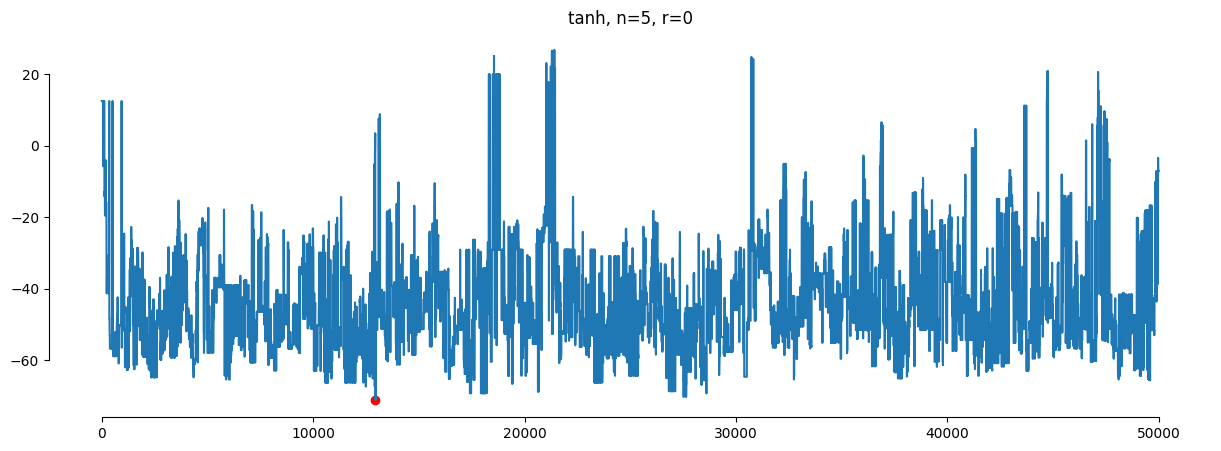

In [62]:
Nini = 00
plt.figure(figsize=(15, 5))

#Define figure size in cm                                                                           
Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
plt.title(str(function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini])
plt.scatter(minrow['t'], minH,color='r')
sns.despine(trim=True)

Name_figure='Energy_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in Extensions:
        plt.savefig('../results/' + Name_figure + ext,dpi=300)

 
plt.show()

In [1]:
#Plot
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']

train_border=dn.loc[train_size-1]['x1']
print(train_size)
print(train_border)

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)
display(dplot.loc[train_size-1:])

rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm
Extensions=['.png', '.pdf']
#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
fig=figure(figsize=(width,height), dpi=300)                                                        

#plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='Artificial Neural Network') 

#plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='Bayesian Machine Scientist')
 

plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed data') 
#plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma) ) 

plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label=r'$\sigma$=' + str(sigma) ) 
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
#plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

#plt.xlim(-4.5,4.5);plt.ylim(-1.1,1.5) 
plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Prediction_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

NameError: name 'dn' is not defined

In [76]:
#Interpolation/extrapolation

In [49]:
#Read high resolution data
resolution=0.001
filename_high_res='../data/generative_data/NN_function_' + str(function) +  '_NREP_10' + '_res_' + str(resolution) + '_data.csv'
dhr=pd.read_csv(filename_high_res,index_col=0)

dhr=dhr[dhr['rep']==n]
dnhr=dhr[(dhr['x1']>=-2.0) & (dhr['x1']<=2.0)]
dnhr=dnhr.reset_index(drop=True)

x = dnhr[[c for c in VARS]].copy()
y = dnhr.y

display(dnhr)

interpol_size=dnhr.index[ (dnhr['x1']<=1.00) & (dnhr['x1']>0.99)][0]

print(interpol_size)
#display(train_border_new)


,x1,y,rep
0,-1.999,0.026939,8.0
1,-1.998,0.026986,8.0
2,-1.997,0.027033,8.0
3,-1.996,0.027080,8.0
4,-1.995,0.027126,8.0
...,...,...,...
3995,1.996,0.993333,8.0
3996,1.997,0.993372,8.0
3997,1.998,0.993410,8.0
3998,1.999,0.993448,8.0


2990


,x1,y,rep,ybms
3175,1.176,0.887220,8.0,0.889103
3176,1.177,0.887502,8.0,0.889401
3177,1.178,0.887783,8.0,NaN
3178,1.179,0.888064,8.0,NaN
3179,1.180,0.888344,8.0,NaN
...,...,...,...,...
3995,1.996,0.993333,8.0,NaN
3996,1.997,0.993372,8.0,NaN
3997,1.998,0.993410,8.0,NaN
3998,1.999,0.993448,8.0,NaN


KeyError: 'y_noise'

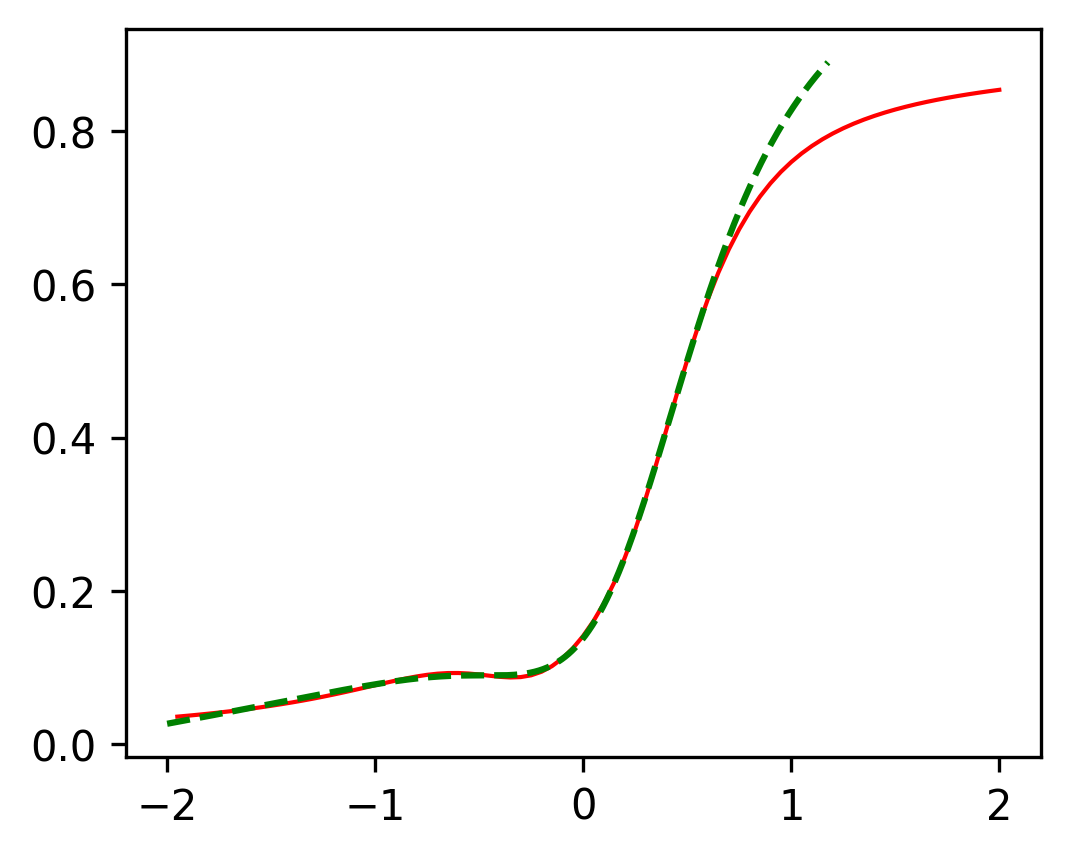

In [63]:
#BMS predictions
dinterpol=deepcopy(dnhr)
dinterpol['ybms']=t.predict(x)
display(dinterpol.loc[interpol_size+185:])


rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])

#rmse_mdl=root_mean_squared_error(dinterpol.ybms,dinterpol.y)
rmse_mdl_inter=root_mean_squared_error(dinterpol.loc[:interpol_size-1]['ybms'],dinterpol.loc[:interpol_size-1]['y'])
#rmse_mdl_extra =root_mean_squared_error(dinterpol.loc[interpol_size-1:]['ybms'],dinterpol.loc[interpol_size-1:]['y'])
 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
#plt.plot(dinterpol.x1, dinterpol.ybms, color='green', linestyle='--', label='mdl.  rmse_inter= %.2E, rmse_extra= %.2E' % ( rmse_mdl_inter, rmse_mdl_extra))

plt.plot(dinterpol.x1, dinterpol.ybms, color='green', linestyle='--', label='mdl.  rmse_inter= %.2E, rmse_extra= ' % ( rmse_mdl_inter))
#plt.plot(dinterpol['x1'], dinterpol['y'],'.', markersize=0.75, color='blue',label='observed')
plt.plot(dinterpol['x1'], dinterpol['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma))
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

#plt.xlim(-4.5,4.5);plt.ylim(-1.1,1.5) 
plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Interpolation_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

In [36]:
#import pyrenn
#try to load nn
#weights='../data/trained_nns/' + 'NN_weights_no_overfit_' + function + '_sigma_\
' + str(sigma) + '_rep_' + str(n) + '_r_' + str(realization) + '.csv'
#test_nn = pyrenn.loadNN(weights)

SyntaxError: unterminated string literal (detected at line 4) (2645362209.py, line 4)